## ATAC + MULTIOME GERM CELLS

### Transcription factor motif enrichment with Seurat

In [11]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.20.0
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_res

In [5]:
print(anndata2ri.__version__)
print(anndata.__version__)

1.0.6
0.7.5


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(Signac)
library(Seurat)
library(SeuratDisk)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

For future reference most packages were installed here: */tmp/RtmpGjkK1o/downloaded_packages/*

**Set directories**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/germcells_apr2021/"
experiment_prefix = 'germcells_'

**Load databases of position frequency matrices**

In [9]:
%%R -o pfm

# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv10')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}


# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
#print(names(pfmHOMER))
names(pfmHOMER)[93] = "FOXL2.HOMER"
 
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)
print(names(pfmHOMER))

for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}


# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
}

# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

  [1] "AP-1.HOMER"                "FOXA1:AR.HOMER"           
  [3] "ARE.HOMER"                 "IRF:BATF.HOMER"           
  [5] "BATF.HOMER"                "BMAL1.HOMER"              
  [7] "BMYB.HOMER"                "BORIS.HOMER"              
  [9] "CDX4.HOMER"                "CEBP:AP1.HOMER"           
 [11] "CEBP:CEBP.HOMER"           "CEBP.HOMER"               
 [13] "CHR.HOMER"                 "CLOCK.HOMER"              
 [15] "COUP-TFII.HOMER"           "CRE.HOMER"                
 [17] "CRX.HOMER"                 "CTCF.HOMER"               
 [19] "DMRT1.HOMER"               "DMRT6.HOMER"              
 [21] "RAR:RXR.HOMER"             "RAR:RXR.HOMER"            
 [23] "E2A.HOMER"                 "E2F1.HOMER"               
 [25] "E2F4.HOMER"                "E2F6.HOMER"               
 [27] "E2F7.HOMER"                "E2F.HOMER"                
 [29] "E2A.HOMER"                 "EBF.HOMER"                
 [31] "EBF1.HOMER"                "EBNA1.HOMER"              
 [33] "E

In [10]:
pfm

<rpy2.robjects.methods.RS4 object at 0x7f02eac6d380> [RTYPES.S4SXP]
R classes: ('PFMatrixList',)

#### Convert the h5ad created with cisTopic into a Seurat object with peaks assay

In [12]:
ATAC_scanpy = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
ATAC_scanpy

AnnData object with n_obs × n_vars = 1998 × 86770
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0_75', 'PGC_mitotic', 'PGC', 'pre-spermatogonia', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiosis', 'oocyte', 'max', 'leiden', 'clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_11', 'X_cistopic_14', 'X_cistopic_18', 'X_cistopic_20', 

In [12]:
ATAC_scanpy.X

<1998x86770 sparse matrix of type '<class 'numpy.float32'>'
	with 9477663 stored elements in Compressed Sparse Row format>

In [13]:
binary_raw = ATAC_scanpy.layers['binary_raw']
binary_raw

<1998x86770 sparse matrix of type '<class 'numpy.float32'>'
	with 9477663 stored elements in Compressed Sparse Row format>

In [14]:
binary_raw.shape

(1998, 86770)

Step 1: from sparse matrix (python format) to dgcMatrix (R format)

I found this function here: <https://github.com/theislab/anndata2ri/issues/8>

In [15]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [16]:
ATAC_R = csr_to_dgc(binary_raw)
ATAC_R

<rpy2.robjects.methods.RS4 object at 0x7f00e2882ac0> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [17]:
%%R -i ATAC_R -o ATAC_dgT

ATAC_dgT <- as(ATAC_R, "dgTMatrix")
print(dim(ATAC_dgT)) # Check the shape of the matrix 

[1] 86770  1998


Step 2: save metadata per cell and per peak and add colnames and rownames to the peak matrix

In [18]:
metadata_cell = ATAC_scanpy.obs
metadata_peak = ATAC_scanpy.var
layers = ATAC_scanpy.layers
reduction_cistopic = ATAC_scanpy.obsm['X_cistopic_20']
reduction_umap = ATAC_scanpy.obsm['X_umap']
#reduction_harmony = ATAC_scanpy.obsm['X_harmony']

In [19]:
del ATAC_scanpy.obs['cellatac_clusters']

In [20]:
%%R -i ATAC_dgT -i metadata_cell -i metadata_peak 

rownames(ATAC_dgT) <- rownames(metadata_peak) # Add rownames to peak matrix
colnames(ATAC_dgT) <- rownames(metadata_cell) # Add colnames to peak matrix 

In [21]:
%%R 
print(head(rownames(ATAC_dgT)))
print(head(colnames(ATAC_dgT)))
print(names(ATAC_dgT))

[1] "chr1:827160-827681" "chr1:869566-870136" "chr1:876828-877075"
[4] "chr1:904549-904946" "chr1:910098-910685" "chr1:912919-913169"
[1] "01-ACAGAAAAGAGGAATG-1" "01-ACTTTCAAGGGCTCTC-1" "01-AGCCAGCAGGTGTCGA-1"
[4] "01-CAGCTAATCTGGCGCA-1" "01-GCACCTTGTTACGGAG-1" "01-GCTCCTACATTACTTC-1"
NULL


Step 3: build ChromatinAssay with peaks x cells matrix 

In [22]:
%%R -o chrom_assay 

 chrom_assay <- CreateChromatinAssay(
    counts = ATAC_dgT,
    sep = c(":", "-"),
    genome = "hg38",
    ranges = NULL,
 )
chrom_assay

ChromatinAssay data with 86770 features for 1998 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 


Step 4: build Seurat object from chromatin assay 

In [23]:
%%R -o ATAC_Seurat -i metadata_cell

ATAC_Seurat <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = metadata_cell,
  )
ATAC_Seurat

An object of class Seurat 
86770 features across 1998 samples within 1 assay 
Active assay: peaks (86770 features, 0 variable features)


In [24]:
%%R 
print(table(ATAC_Seurat@meta.data$individual))
print(table(ATAC_Seurat@meta.data$leiden))


  F81  Hrv3 Hrv13 Hrv15 Hrv17 Hrv18 Hrv21 Hrv39 Hrv49 Hrv50 Hrv58 Hrv59 
   14   221    48    71     4    14     9   456   214   643    14   290 

  0   1   2   3   4   5   6   7   8   9  10  11  12  13 
300 278 193 177 165 156 137 136 126 112  92  86  31   9 


Step 5: Add dimensionality reductions to Seurat object 

In [25]:
%%R -i reduction_cistopic -i metadata_cell -o reduction_cistopic_2 

reduction_cistopic_2 <- data.matrix(reduction_cistopic)
key <- "cisTopic_"
colnames(reduction_cistopic_2) <- paste0(key, 1:ncol(x = reduction_cistopic_2))
rownames(reduction_cistopic_2) <- rownames(metadata_cell)
#print(head(reduction_cistopic_2))

In [26]:
%%R -i reduction_umap -i metadata_cell -o reduction_umap_2 

reduction_umap_2 <- data.matrix(reduction_umap)
key2 <- "UMAP_"
colnames(reduction_umap_2) <- paste0(key2, 1:ncol(x = reduction_umap_2))
rownames(reduction_umap_2) <- rownames(metadata_cell)
#print(head(reduction_umap_2))

In [27]:
#%%R -i reduction_harmony -i metadata_cell -o reduction_harmony_2 

#reduction_harmony_2 <- data.matrix(reduction_harmony)
#key3 <- "Harmony_"
#colnames(reduction_harmony_2) <- paste0(key3, 1:ncol(x = reduction_harmony_2))
#rownames(reduction_harmony_2) <- rownames(metadata_cell)
#print(head(reduction_harmony_2))

In [28]:
%%R 

ATAC_Seurat@reductions$cisTopics <- CreateDimReducObject(embeddings = reduction_cistopic_2, assay = "peaks")
ATAC_Seurat@reductions$umap <- CreateDimReducObject(embeddings = reduction_umap_2, assay = "peaks")
#ATAC_Seurat@reductions$harmony <- CreateDimReducObject(embeddings = reduction_harmony_2, assay = "peaks")
ATAC_Seurat

An object of class Seurat 
86770 features across 1998 samples within 1 assay 
Active assay: peaks (86770 features, 0 variable features)
 2 dimensional reductions calculated: cisTopics, umap


In [29]:
%%R
ATAC_Seurat@reductions$umap

A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks 


In [30]:
%%R
ATAC_Seurat@reductions$cisTopics

A dimensional reduction object with key cisTopic_ 
 Number of dimensions: 20 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks 


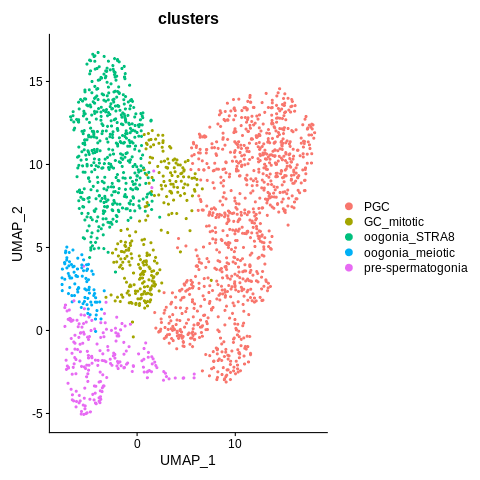

In [31]:
%%R 

DimPlot(object = ATAC_Seurat, group.by = "clusters")

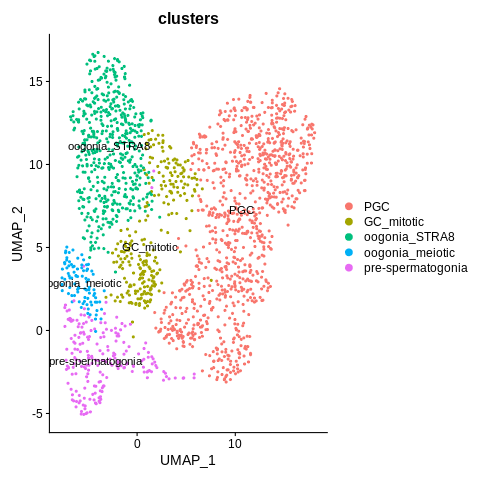

In [32]:
%%R 

DimPlot(object = ATAC_Seurat, group.by = "clusters", label = TRUE)

#### Add motifs

In [33]:
%%R -o ATAC_Seurat_withMotifs

ATAC_Seurat_withMotifs <- AddMotifs(object = ATAC_Seurat, 
                         genome= BSgenome.Hsapiens.UCSC.hg38, 
                         pfm = pfm, 
                         assay = "peaks", 
                         verbose = TRUE)

ATAC_Seurat_withMotifs

An object of class Seurat 
86770 features across 1998 samples within 1 assay 
Active assay: peaks (86770 features, 0 variable features)
 2 dimensional reductions calculated: cisTopics, umap


#### Compute per-cell motif activity scores with chromVar

In [34]:
%%R -o ATAC_Seurat_withChromVar

library(BiocParallel)
register(SerialParam())
ATAC_Seurat_withChromVar <- RunChromVAR(
  object = ATAC_Seurat_withMotifs,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  assay="peaks"
)
ATAC_Seurat_withChromVar

An object of class Seurat 
88690 features across 1998 samples within 2 assays 
Active assay: peaks (86770 features, 0 variable features)
 1 other assay present: chromvar
 2 dimensional reductions calculated: cisTopics, umap


Intermediate saving just in case 

In [35]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat_withChromVar, file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))

In [36]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat, file = paste0(outdir, experiment_prefix, "_ATAC_Seurat.rds"))

#### Test for differential accessibility scores between cell types (leiden clusters)

In [37]:
%%R -i pfm -o motif2names

library(dplyr) 
motif2names <- lapply(pfm, function(x) x@name)
names(motif2names) <- sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [38]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [39]:
%%R 

Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$clusters

In [40]:
%%R 

print(table(ATAC_Seurat_withChromVar@meta.data$clusters))


              PGC        GC_mitotic     oogonia_STRA8   oogonia_meiotic 
              966               248               493                86 
pre-spermatogonia 
              205 


In [41]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(ATAC_Seurat_withChromVar, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'TFs/DARs/all_DA_peaks_LR.csv'))

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~18s           |++                                                | 2 % ~17s           |++                                                | 3 % ~18s           |+++                                               | 4 % ~18s           |+++                                               | 5 % ~18s           |++++                                              | 6 % ~19s           |++++                                              | 7 % ~20s           |+++++                                             | 8 % ~19s           |+++++                                             | 9 % ~18s           |++++++                                            | 10% ~17s           |++++++                                            | 11% ~16s           |+++++++                                           | 12% ~16s           |+++++++                                           | 14% ~15s 

**Find TFs of interest**

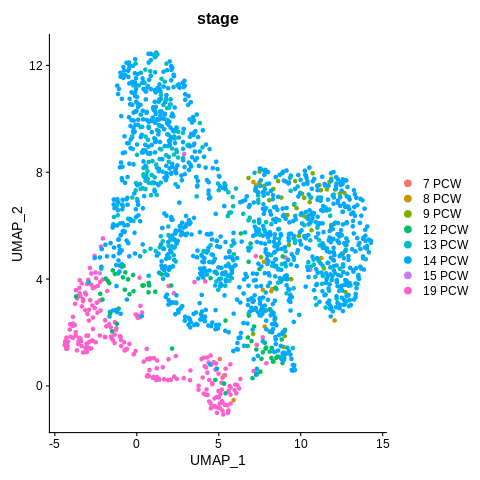

In [139]:
%%R 

DimPlot(object = ATAC_Seurat, group.by = "stage", pt.size = 1.5)

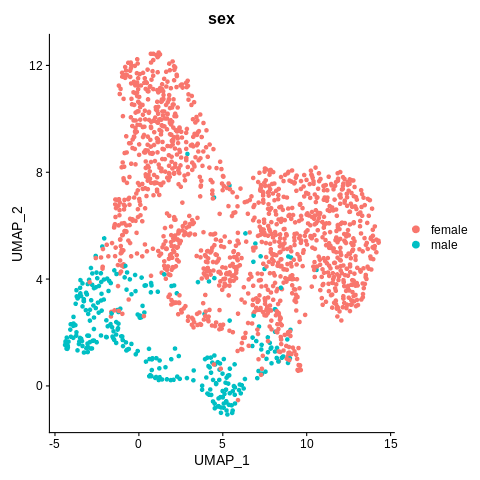

In [140]:
%%R 

DimPlot(object = ATAC_Seurat, group.by = "sex", pt.size = 1.5)

In [26]:
%%R 

DimPlot(object = ATAC_Seurat, group.by = "clusters", pt.size = 1.5)


Error in is(x, "classRepresentation") : object 'ATAC_Seurat' not found


#### Transcription Factor motif enrichemnt per leiden cluster

In [9]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar = readRDS(paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))
DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 
Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$clusters
print(table(ATAC_Seurat_withChromVar@meta.data$clusters))


              PGC        GC_mitotic     oogonia_STRA8   oogonia_meiotic 
              966               248               493                86 
pre-spermatogonia 
              205 


In [10]:
%%R -o chromvar_assay

chromvar_assay <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_Seurat_withChromVar))))

In [13]:
# Mapping of cells to cell types 
ATAC_scanpy.obs['barcode'] = ATAC_scanpy.obs_names
cells_celltypes = ATAC_scanpy.obs[['barcode', 'clusters']]
cells_celltypes.head()

,barcode,clusters
01-ACAGAAAAGAGGAATG-1,01-ACAGAAAAGAGGAATG-1,PGC
01-ACTTTCAAGGGCTCTC-1,01-ACTTTCAAGGGCTCTC-1,PGC
01-AGCCAGCAGGTGTCGA-1,01-AGCCAGCAGGTGTCGA-1,PGC
01-CAGCTAATCTGGCGCA-1,01-CAGCTAATCTGGCGCA-1,PGC
01-GCACCTTGTTACGGAG-1,01-GCACCTTGTTACGGAG-1,PGC


In [14]:
cells_mapping_clusters = cells_celltypes.groupby('clusters').groups

In [15]:
# Mean by rows 
for key in cells_mapping_clusters: 
    print(key)
    chromvar_assay.loc[key] = chromvar_assay.loc[cells_mapping_clusters[key]].mean(axis = 0)

PGC
GC_mitotic
oogonia_STRA8
oogonia_meiotic
pre-spermatogonia


In [16]:
rows_celltypes = list(np.unique(cells_celltypes['clusters']))
print(rows_celltypes)
# Select only aggregated rows
chromvar_assay = chromvar_assay.loc[rows_celltypes, ]

['GC_mitotic', 'PGC', 'oogonia_STRA8', 'oogonia_meiotic', 'pre-spermatogonia']


In [17]:
# Normalize by column (TF)
from scipy.stats import zscore
chromvar_assay_zscore = chromvar_assay.apply(zscore)

In [18]:
chromvar_assay_zscore.to_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv")

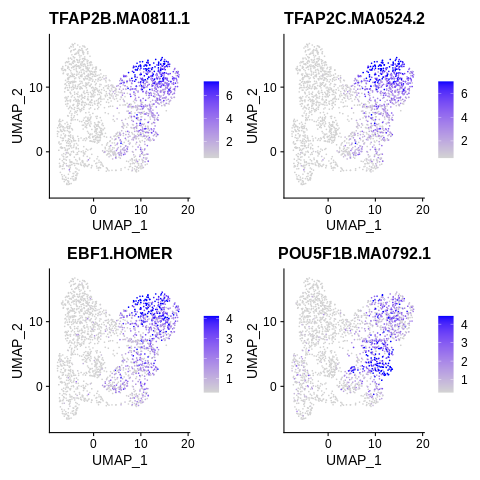

In [25]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("TFAP2B.MA0811.1", "TFAP2C.MA0524.2", "EBF1.HOMER", "POU5F1B.MA0792.1"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

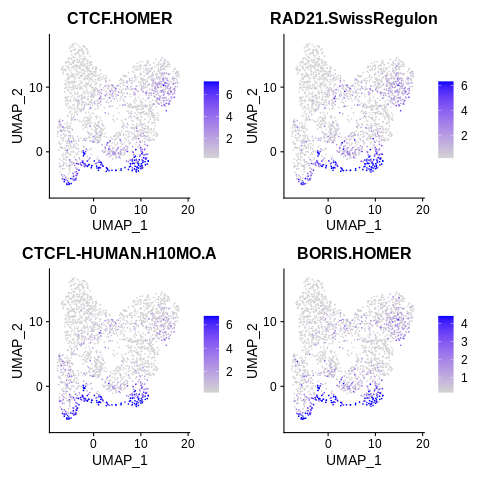

In [24]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("CTCF.HOMER", "RAD21.SwissRegulon", "CTCFL-HUMAN.H10MO.A", "BORIS.HOMER"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

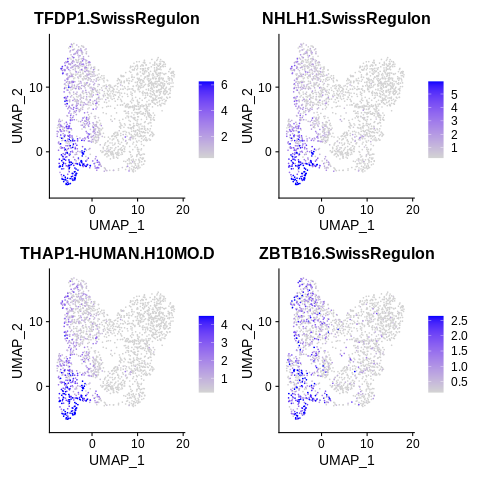

In [23]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("TFDP1.SwissRegulon", "NHLH1.SwissRegulon", "THAP1-HUMAN.H10MO.D", "ZBTB16.SwissRegulon"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

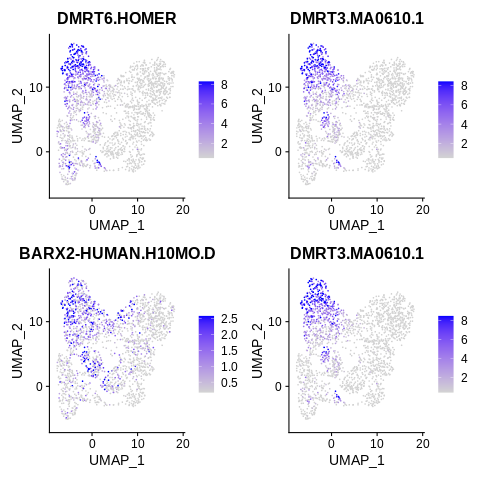

In [19]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("DMRT6.HOMER", "DMRT3.MA0610.1", "BARX2-HUMAN.H10MO.D", "DMRT3.MA0610.1"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

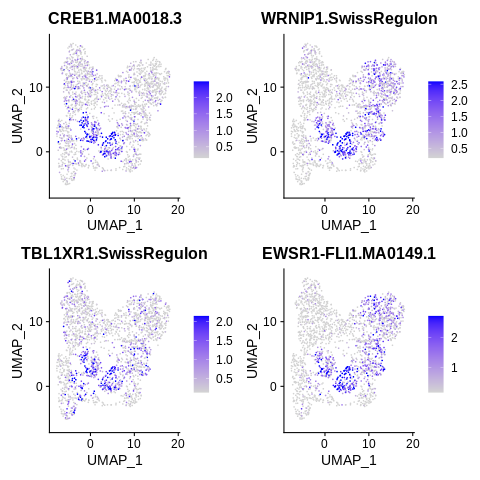

In [20]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("CREB1.MA0018.3", "WRNIP1.SwissRegulon", "TBL1XR1.SwissRegulon", "EWSR1-FLI1.MA0149.1"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

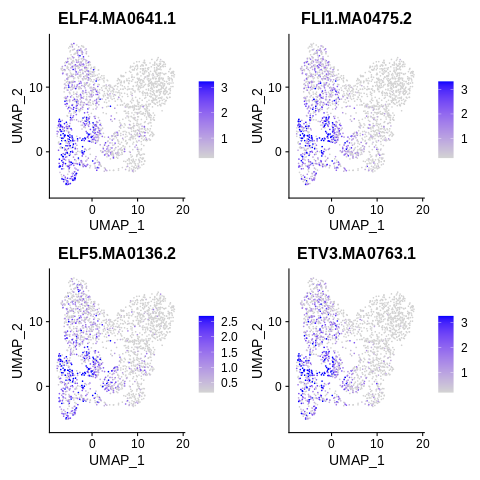

In [21]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("ELF4.MA0641.1", "FLI1.MA0475.2", "ELF5.MA0136.2", "ETV3.MA0763.1"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

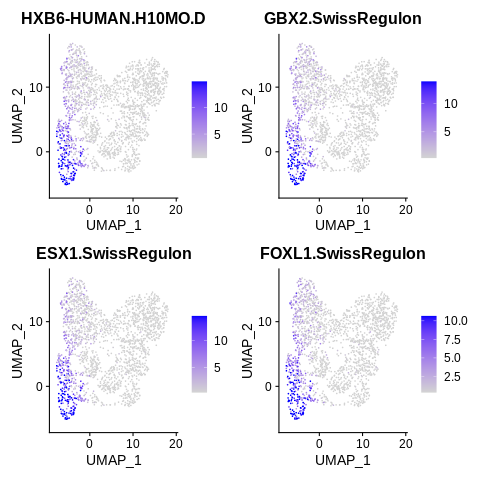

In [22]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("HXB6-HUMAN.H10MO.D", "GBX2.SwissRegulon", "ESX1.SwissRegulon", "FOXL1.SwissRegulon"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

#### End of notebook